In [2]:
import pandas as pd 
matches = pd.read_csv("matches.csv", index_col = 0)

##converting all objects to int or float to be processed by the machine learning software
matches["date"] = pd.to_datetime(matches["date"])
matches["h/a"] = matches["venue"].astype("category").cat.codes ## converting venue to a home (1) or away (0) number
matches["opp"] = matches["opponent"].astype("category").cat.codes ## converting opponents to a number
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int") ## converting hours to number in case a team plays better at a certain time
matches["day"] = matches["date"].dt.dayofweek ## converting day of week of game to a number

matches["target"] = (matches["result"] == "W").astype("int") ## setting a win to the value 1

from sklearn.ensemble import RandomForestClassifier ##importing machine learning for non linear data

rf = RandomForestClassifier(n_estimators = 100, min_samples_split=10, random_state=1)
train = matches[matches["date"] < '2024-01-01'] 
test = matches[matches["date"] > '2024-01-01']
predictors = ["h/a", "opp", "hour", "day"]
rf.fit(train[predictors], train["target"])
RandomForestClassifier(min_samples_split = 10, n_estimators = 100, random_state = 1)
preds = rf.predict(test[predictors]) ##making prediction

from sklearn.metrics import accuracy_score
acc = accuracy_score(test["target"], preds) ## testing accuracy
acc
combined = pd.DataFrame(dict(actual=test["target"], prediction=preds))
pd.crosstab(index=combined["actual"], columns=combined["prediction"])

from sklearn.metrics import precision_score
precision_score(test["target"], preds)

grouped_matches = matches.groupby("team") 
group = grouped_matches.get_group("Manchester United").sort_values("date")
 
def rolling_averages(group, cols, new_cols): ## function to take into consideration form of a team
    group = group.sort_values("date") ## sorting games by date 
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols) ##droping missing values and replacing with empty
    return group 

cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"] 
new_cols = [f"{c}_rolling" for c in cols] ## creating new columns with rolling average values 

rolling_averages(group, cols, new_cols) ## calling function and generating average of last 3 games

matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_rolling = matches_rolling.droplevel('team') ## dropping extra index level

matches_rolling.index = range(matches_rolling.shape[0]) ## adding new index
matches_rolling

def make_predictions(data, predictors): ## making the predictions
    train = data[data["date"] < '2024-01-01'] 
    test = data[data["date"] > '2024-01-01']
    rf.fit(train[predictors], train["target"])
    preds = rf.predict(test[predictors]) ##making prediction
    combined = pd.DataFrame(dict(actual=test["target"], prediction=preds), index=test.index)
    precision = precision_score(test["target"], preds)
    return combined, precision ## returning the values for the prediction

combined, precision = make_predictions(matches_rolling, predictors + new_cols)

precision

combined 

combined = combined.merge(matches_rolling[["date", "team", "opponent", "result"]], left_index = True, right_index = True)
combined

class MissingDict(dict): ## creating a class that inherits from the dictionary class
    __missing__ = lambda self, key: key ## in case a team name is missing

map_values = {
    "Brighton and Hove Albion": "Brighton",
    "Manchester United": "Manchester Utd",
    "Tottenham Hotspur": "Tottenham", 
    "West Ham United": "West Ham", 
    "Wolverhampton Wanderers": "Wolves"
}
mapping = MissingDict(**map_values)
mapping["West Ham United"]

combined["new_team"] = combined["team"].map(mapping)
combined

merged = combined.merge(combined, left_on=["date", "new_team"], right_on=["date", "opponent"]) ## finding both the home and away team predictions and merging them 
merged

/var/folders/57/_ws0s1mx0xn9zc9gm8f422bw0000gn/T/ipykernel_33364/886936443.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))


,actual_x,prediction_x,date,team_x,opponent_x,result_x,new_team_x,actual_y,prediction_y,team_y,opponent_y,result_y,new_team_y
0,1,0,2024-01-20,Arsenal,Crystal Palace,W,Arsenal,0,0,Crystal Palace,Arsenal,L,Crystal Palace
1,1,1,2024-01-30,Arsenal,Nott'ham Forest,W,Arsenal,0,0,Nottingham Forest,Arsenal,L,Nottingham Forest
2,1,1,2024-02-04,Arsenal,Liverpool,W,Arsenal,0,0,Liverpool,Arsenal,L,Liverpool
3,1,0,2024-02-11,Arsenal,West Ham,W,Arsenal,0,0,West Ham United,Arsenal,L,West Ham
4,1,0,2024-02-17,Arsenal,Burnley,W,Arsenal,0,0,Burnley,Arsenal,L,Burnley
...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,0,0,2024-08-31,Wolverhampton Wanderers,Nott'ham Forest,D,Wolves,0,1,Nottingham Forest,Wolves,D,Nottingham Forest
418,0,0,2024-09-15,Wolverhampton Wanderers,Newcastle Utd,L,Wolves,1,0,Newcastle United,Wolves,W,Newcastle United
419,0,0,2024-09-21,Wolverhampton Wanderers,Aston Villa,L,Wolves,1,1,Aston Villa,Wolves,W,Aston Villa
420,0,0,2024-09-28,Wolverhampton Wanderers,Liverpool,L,Wolves,1,0,Liverpool,Wolves,W,Liverpool


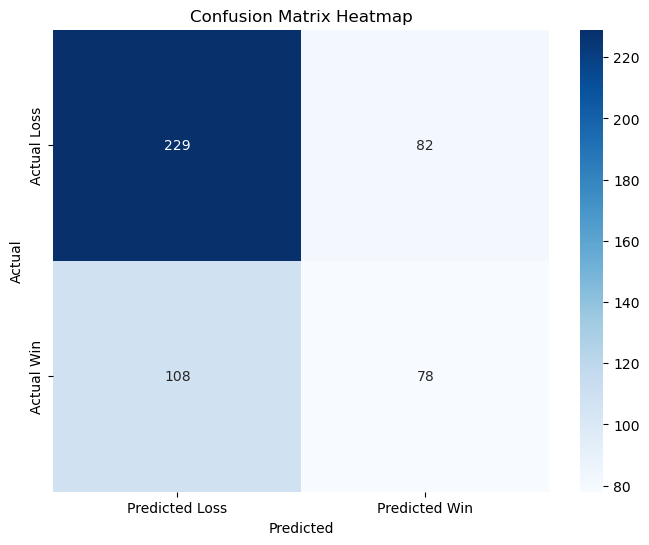

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'combined' DataFrame has 'prediction' and 'actual' columns
predictions = combined["prediction"]
actuals = combined["actual"]

# Calculate confusion matrix
cm = confusion_matrix(actuals, predictions)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Loss', 'Predicted Win'], yticklabels=['Actual Loss', 'Actual Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()